In [1]:
import json
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp, odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import cm
import seaborn as sns

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams['font.weight'] = 'bold'

# Circadian Clock Model from the Literature

Circadian clock/rhythm is a periodic oscillation observed in several living forms and humans. These clocks/rhythms influence several process in the living body such as temperature regulation, sleep-wake cycles, metabolism, hormone production, etc. Any fluctuation or change in the clock can thus have a larger effect or disorder.

A group of genes and proteins govern the clock with various models in the literature to simulate the clock and study their lasting impact on our health. Here, we have demonstrated a model from the literature to show various genes and proteins which govern the clock. The list of genes and proteins can be found in the `hesse_species_mapping` dictionary. These elements have been used by Hesse et al. [1] in their paper to study the effects of irinotecan on the mammalian circadian clock. Their model relies on the following reactions of these genes and proteins to study the concentrations of these species, and in turn, the circadian clock:
- degradation of the genes and proteins
- formation and dissociation of protein complexes (as some protein tend to combine and form complexes)
- transcription of genes based on proteins in the system (think as production)
- activating and inhibiting behaviour of the proteins for the genes
- production of proteins from genes
- export and import of these proteins, in and out of the nucleus (cells are made of cytoplasm and nucleus, and these species can exist inside the nucleus or in the cytoplasm)

These reactions provide the parameters for the temporal ODEs for the concentration of these species as observed in `hesse_params_list`.

In [3]:
hesse_species_mapping = {
    "x1": "Clock/Bmal_N",
    "x2": "Per/Cry_N^tot",
    "x5": "Rev-Erb_N",
    "x6": "Ror_N",
    "y1": "Per",
    "y2": "Cry",
    "y3": "Rev-Erb",
    "y4": "Ror",
    "y5": "Bmal",
    "y6": "Clock",
    "z1": "Cry_C",
    "z2": "Per_C^tot",
    "z4": "Per/Cry_C^tot",
    "z5": "Clock_C",
    "z6": "Rev-Erb_C",
    "z7": "Ror_C",
    "z8": "Bmal_C",
    "z9": "Clock/Bmal_C"
}
hesse_params_list = [
    # degradation rates
    'dr_x1', 'dr_x2', 'dr_x5', 'dr_x6',
    'dr_y1', 'dr_y2', 'dr_y3', 'dr_y4', 'dr_y5', 'dr_y6',
    'dr_z1', 'dr_z2', 'dr_z5', 'dr_z6', 'dr_z7', 'dr_z8',
    # reaction rates for complex formation/dissociation
    'kf_z9', 'kf_z4', 'kd_z9', 'kd_z4',
    # transcription rates
    'tr_y1', 'tr_y2', 'tr_y3', 'tr_y4', 'tr_y5', 'tr_y6',
    # activation/inhibition rates
    'ar_y1', 'ar_y2', 'ar_y3', 'ar_y4', 'ar_y5', 'ar_y6',
    'ir_y1', 'ir_y2', 'ir_y21', 'ir_y3', 'ir_y4', 'ir_y5', 'ir_y6',
    # transcription fold activation
    'a', 'd', 'g', 'h', 'i', 'j',
    # production rates
    'pr_z1', 'pr_z2', 'pr_z5', 'pr_z6', 'pr_z7', 'pr_z8',
    # import/export rates
    'impr_z4', 'impr_z6', 'impr_z7', 'impr_z9',
    'expr_x1', 'expr_x2',
    # hill coefficients
    'b', 'c', 'e', 'f', 'f1',
    # volume proportions
    'vc', 'vn'
]

In [4]:
def hesse_initialize_params(literature = False):
    '''
    Args >>>
    - literature: boolean
    
    To use the parameters from the literature, set the boolean to True.
    These parameters from the literature are to test and validate our results.
    '''
    if literature:
        return pd.concat([
            pd.read_json('hesse/degradation_rates.json', typ = 'series'),
            pd.read_json('hesse/reaction_rates.json', typ = 'series'),
            pd.read_json('hesse/transcription_rates.json', typ = 'series'),
            pd.read_json('hesse/activation_inhibition_rates.json', typ = 'series'),
            pd.read_json('hesse/transcription_fold_activation_rates.json', typ = 'series'),
            pd.read_json('hesse/production_rates.json', typ = 'series'),
            pd.read_json('hesse/import_export_rates.json', typ = 'series'),
            pd.read_json('hesse/hill_coefficients_of_transcription.json', typ = 'series'),
            pd.read_json('hesse/volume_proportions.json', typ = 'series')
        ])
    else:
        tmp = np.random.rand()
        values = np.concatenate((
            np.random.rand(16), # degradation rates
            np.random.rand(2), # reaction rates for complex formation
            np.random.rand(2), # reaction rates for complex dissociation
            np.random.rand(6), # transcription rates
            np.random.rand(13), # activation/inhibition rates
            np.random.rand(6) * 10, # transcription fold activation
            np.random.rand(6) * 1e3, # production rates
            np.random.rand(6), # import/export rates
            np.random.rand(5), # hill coefficients
            np.array([tmp, 1-tmp]) # volume proportions
        ))
        return pd.Series(values, hesse_params_list)

THe clock is a result of 18 ODEs which describe the change in concentration of these species. The function `hesse_circadian_clock` computes the derivatives to assist a ODE solver to arrive at a solution for the system.

In [45]:
def hesse_circadian_clock(t, species, params):
    '''
    function to compute the derivatives in the circadian clock model
    - these odes are based on the model proposed by Relogio et al. (2011) [2]
      and later modified by Hesse et al. (2021) [1]
    this is just the core clock which does not capture any interactions with external factors like drugs or stimuli (like light)
    '''
    # unpacking the values of the proteins and genes
    x1, x2, x5, x6 = species[:4]
    y1, y2, y3, y4, y5 = species[4:9]
    z1, z2, z4, z5, z6, z7, z8, z9 = species[9:17]
    y6 = species[17]
    ratio = params['vc'] / params['vn']

    # odes for nuclear proteins and protein complexes
    dx1dt = params['impr_z9'] * z9 - params['expr_x1'] * x1 - params['dr_x1'] * x1
    dx2dt = params['impr_z4'] * z4 - params['expr_x2'] * x2 - params['dr_x2'] * x2
    dx5dt = params['impr_z6'] * z6 - params['dr_x5'] * x5
    dx6dt = params['impr_z7'] * z7 - params['dr_x6'] * x6

    # odes for core genes for the circadian clock
    dy1dthelper = (x1 / params['ar_y1'] / 1e-9)**params['b']
    dy1dt = params['tr_y1'] * 1e-9 * (1 + params['a'] * dy1dthelper) / (1 + dy1dthelper * (1 + (x2 / params['ir_y1'] / 1e-9)**params['c'])) - params['dr_y1'] * y1
    dy2dthelper = (x1 / params['ar_y2'] / 1e-9)**params['e']
    dy2dt = params['tr_y2'] * 1e-9 * (1 + params['d'] * dy2dthelper) / (1 + dy2dthelper * (1 + (x2 / params['ir_y2'] / 1e-9)**params['f'])) * (1 / (1 + (x5 / params['ir_y21'] / 1e-9)**params['f1'])) - params['dr_y2'] * y2
    dy3dthelper = (x1 / params['ar_y3'] / 1e-9)**params['b']
    dy3dt = params['tr_y3'] * 1e-9 * (1 + params['g'] * dy3dthelper) / (1 + dy3dthelper * (1 + (x2 / params['ir_y3'] / 1e-9)**params['c'])) - params['dr_y3'] * y3
    dy4dthelper = (x1 / params['ar_y4'] / 1e-9)**params['b']
    dy4dt = params['tr_y4'] * 1e-9 * (1 + params['h'] * dy4dthelper) / (1 + dy4dthelper * (1 + (x2 / params['ir_y4'] / 1e-9)**params['c'])) - params['dr_y4'] * y4
    dy5dthelper = (x6 / params['ar_y5'] / 1e-9)**params['b']
    dy5dt = params['tr_y5'] * 1e-9 * (1 + params['i'] * dy5dthelper) / (1 + dy5dthelper + (x5 / params['ir_y5'] / 1e-9)**params['c']) - params['dr_y5'] * y5
    dy6dthelper = (x6 / params['ar_y6'] / 1e-9)**params['b']
    dy6dt = params['tr_y6'] * 1e-9 * (1 + params['j'] * dy6dthelper) / (1 + dy6dthelper + (x5 / params['ir_y6'] / 1e-9)**params['c']) - params['dr_y6'] * y6

    # odes for cytoplasmic proteins and protein complexes
    dz1dt = params['pr_z1'] * y2 + params['kd_z4'] * z4 - params['kf_z4'] * 1e9 * z1 * z2 - params['dr_z1'] * z1
    dz2dt = params['pr_z2'] * y1 + params['kd_z4'] * z4 - params['kf_z4'] * 1e9 * z1 * z2 - params['dr_z2'] * z2
    dz4dt = params['kf_z4'] * 1e9 * z1 * z2 + ratio * params['expr_x2'] * x2 - ratio * params['impr_z4'] * z4 - params['kd_z4'] * z4
    dz5dt = params['pr_z5'] * y6 + params['kd_z9'] * z9 - params['kf_z9'] * 1e9 * z8 * z5 - params['dr_z5'] * z5
    dz6dt = params['pr_z6'] * y3 - ratio * params['impr_z6'] * z6 - params['dr_z6'] * z6
    dz7dt = params['pr_z7'] * y4 - ratio * params['impr_z7'] * z7 - params['dr_z7'] * z7
    dz8dt = params['pr_z8'] * y5 + params['kd_z9'] * z9 - params['kf_z9'] * 1e9 * z5 * z8 - params['dr_z8'] * z8
    dz9dt = params['kf_z9'] * 1e9 * z8 * z5 + ratio * params['expr_x1'] * x1 - ratio * params['impr_z9'] * z9 - params['kd_z9'] * z9
    
    odes = [dx1dt, dx2dt, dx5dt, dx6dt, dy1dt, dy2dt, dy3dt, dy4dt, dy5dt, dz1dt, dz2dt, dz4dt, dz5dt, dz6dt, dz7dt, dz8dt, dz9dt, dy6dt]
    return odes

Now, we use `solve_ivp` routine from the SciPy package with `Radau` RK method to solve the system of ODEs.

In [6]:
# testing the clock with parameters from the literature
with open('hesse/initial_values.json') as f:
    init = json.load(f)
t_start = 0
t_end = 600
dt = 0.1
t_eval = np.linspace(t_start, t_end, int((t_end - t_start)/dt) + 1)
parameters = hesse_initialize_params(True)

In [7]:
soln = solve_ivp(
            fun = lambda t, p: hesse_circadian_clock(t, p, parameters.to_dict()),
            t_span = [t_start, t_end],
            y0 = list(init.values()),
            t_eval = t_eval,
            method = 'Radau',
            atol = 1e-12,
            rtol = 1e-12
        )

The solution clearly shows a periodic trend in the concentration of the genes and proteins. This is an expected outcome from the model using the pre-optimized parameters borrowed from the literature. During the early stages of the project, we planned to implement the general reaction and behaviour of these species as shown in the ODEs while fitting the parameters to experimental data to create a base circadian clock model. This hypothesised model would then be updated to include the effects of a drug on the clock. However, later in the notebook, we diverge to a simpler model which borrows inspiration from the design principles highlighted in the model by Hesse et al. [1].

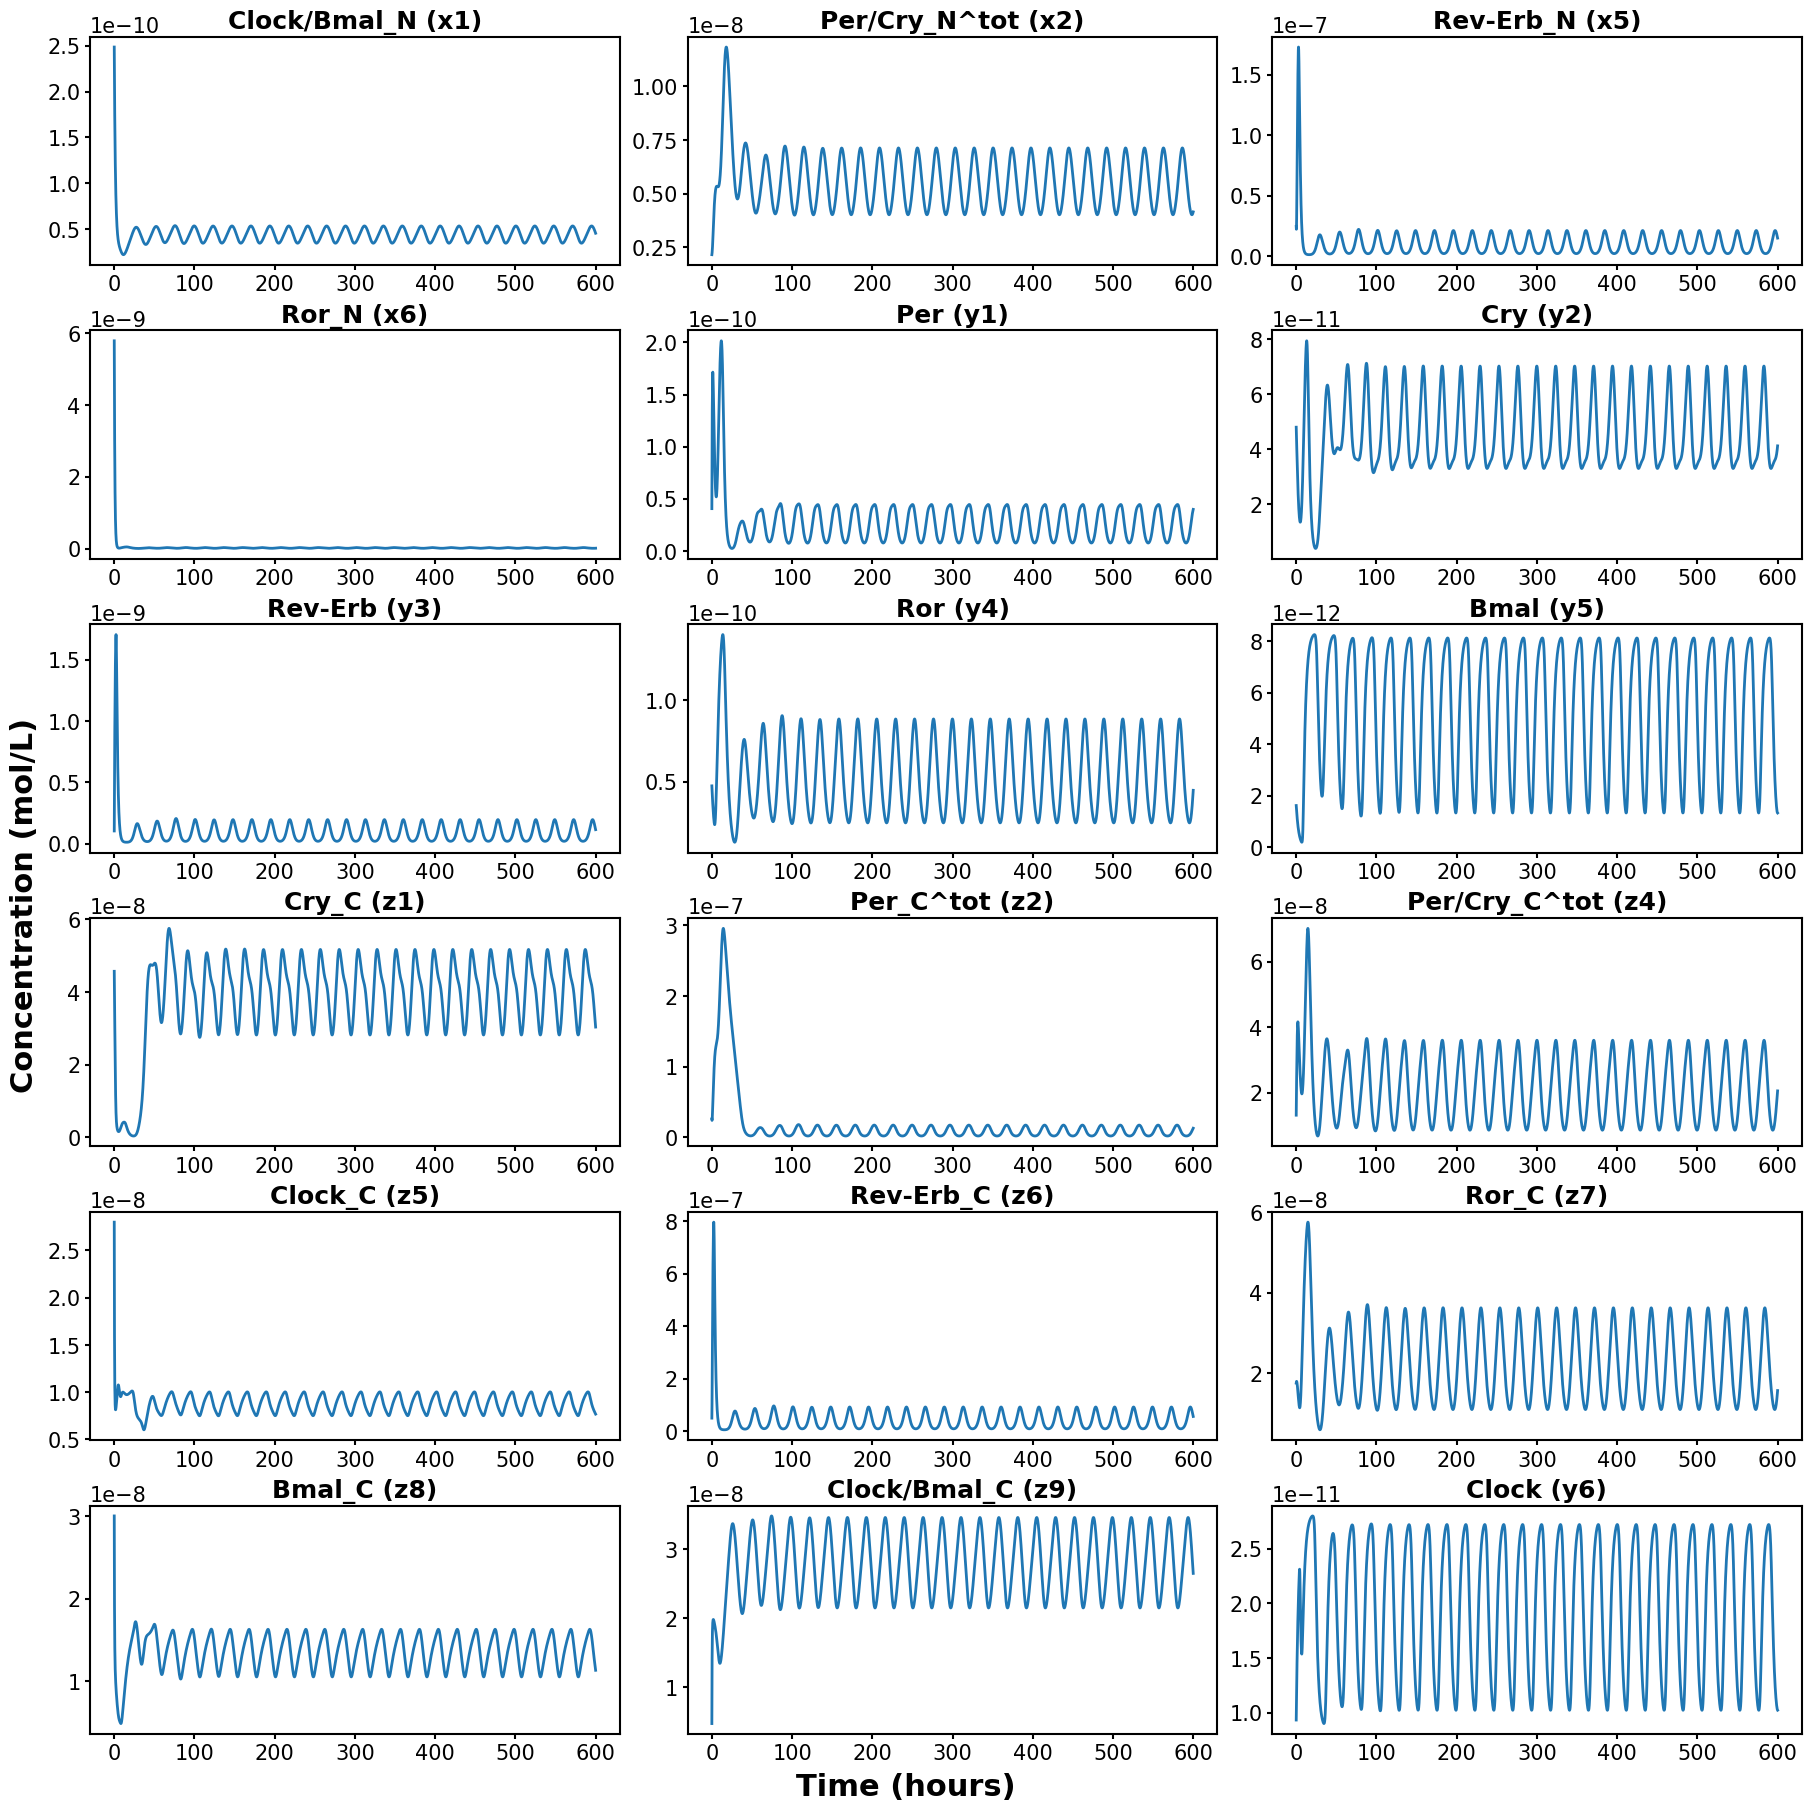

In [8]:
plt_start = int(t_start / dt)
plt_end = int(t_end / dt)
fig, axes = plt.subplots(6, 3, figsize = (18,18), constrained_layout = True)
for i, ax in zip(range(len(init)), axes.flat):
    time = soln.t[plt_start:plt_end]
    prot = soln.y[i, plt_start:plt_end]
    ax.plot(time, prot, label = list(init.keys())[i], lw = 2)
    ax.tick_params(axis='both', which = 'major', labelsize = '15', width = 1.5)
    ax.yaxis.offsetText.set_fontsize(15)
    var = list(init.keys())[i]
    ax.set_title('{} ({})'.format(hesse_species_mapping[var], var), fontsize = 18, weight = 'bold')
_ = fig.supylabel('Concentration (mol/L)', fontsize = 22, weight = 'bold')
_ = fig.supxlabel('Time (hours)', fontsize = 22, weight = 'bold')
# plt.savefig('hesse_circadian_clock_entire_period.png', bbox_inches = 'tight', pad_inches = 0.4, dpi = 300)

A zoomed-in view of the clock.

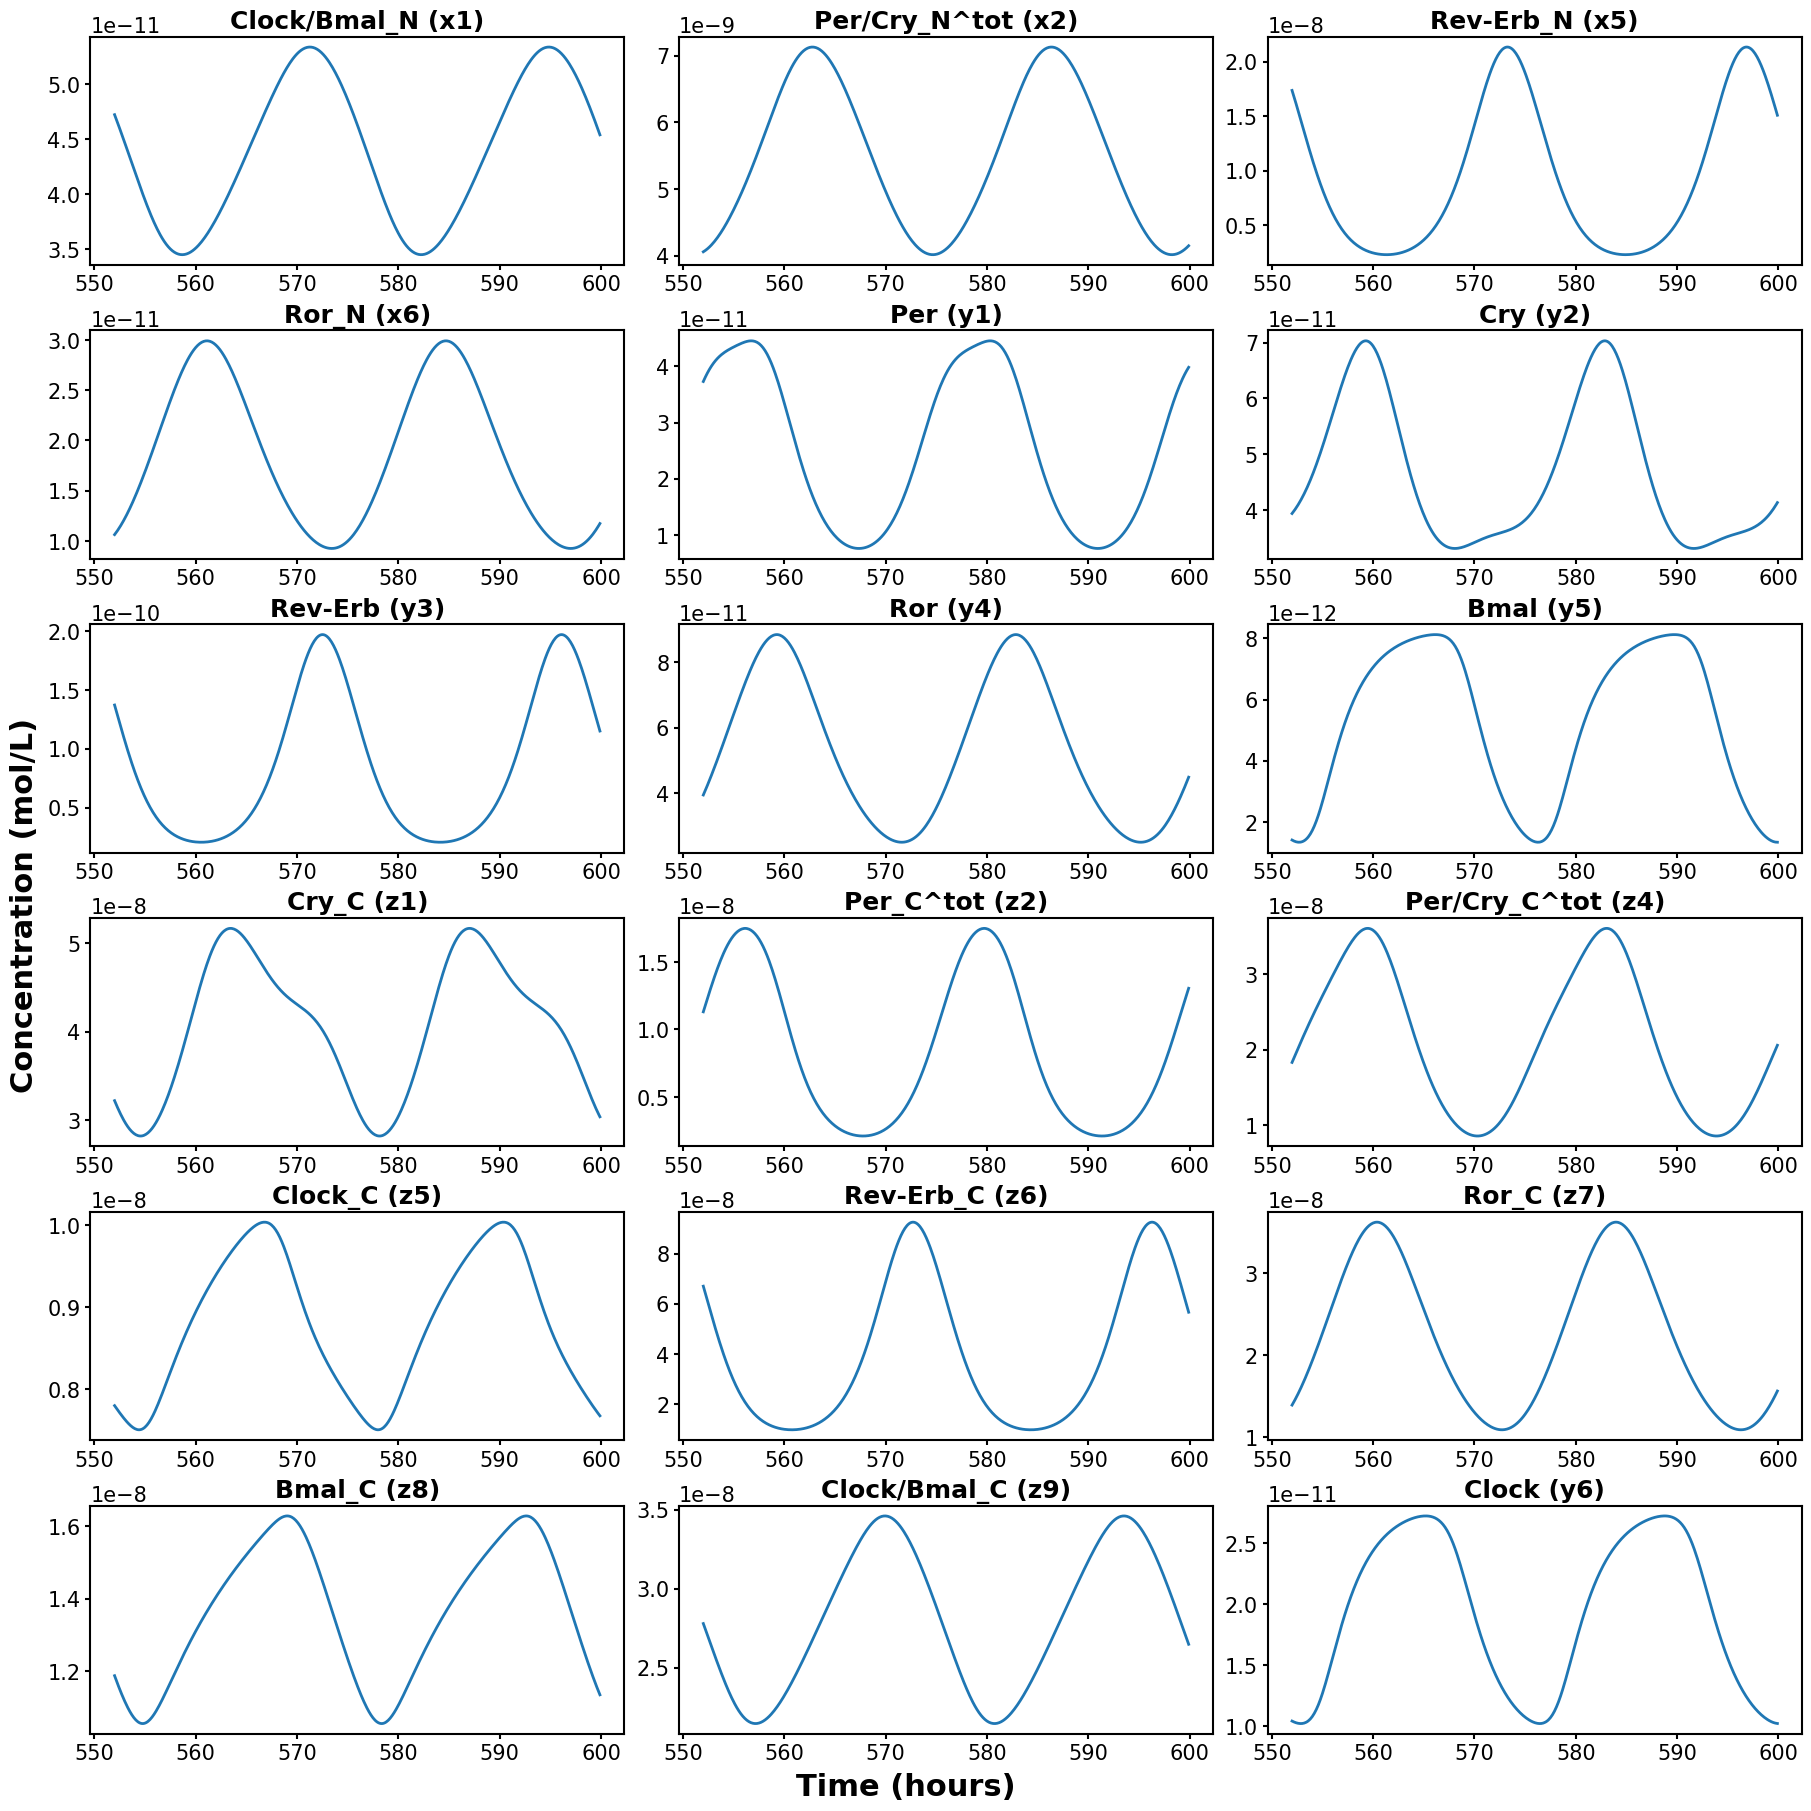

In [9]:
plt_start = int((t_end - 48) / dt)
plt_end = int(t_end / dt)
fig, axes = plt.subplots(6, 3, figsize = (18,18), constrained_layout = True)
for i, ax in zip(range(len(init)), axes.flat):
    time = soln.t[plt_start:plt_end]
    prot = soln.y[i, plt_start:plt_end]
    ax.plot(time, prot, label = list(init.keys())[i], lw = 2)
    ax.tick_params(axis='both', which = 'major', labelsize = '15', width = 1.5)
    ax.yaxis.offsetText.set_fontsize(15)
    var = list(init.keys())[i]
    ax.set_title('{} ({})'.format(hesse_species_mapping[var], var), fontsize = 18, weight = 'bold')
_ = fig.supylabel('Concentration (mol/L)', fontsize = 22, weight = 'bold')
_ = fig.supxlabel('Time (hours)', fontsize = 22, weight = 'bold')
# plt.savefig('hesse_circadian_clock_portion.png', bbox_inches = 'tight', pad_inches = 0.4, dpi = 300)

# Optimization Routine for Parameters

Before we dive into the simpler model to simulate the clock, we discuss the optimization routine and approach to obtain the parameters for the ODEs from experiment data.

Here, the function `sample_model` evaluates the following derivatives and thus assists the solver to arrive at a solution.
$$\frac{dx_1}{dt} = - k_1x_1$$
$$\frac{dx_2}{dt} = k_1x_1 - k_2x_2$$

In [10]:
def sample_model(t, y, params):
    x1, x2 = y
    dx1dt = - params[0] * x1
    dx2dt = params[0] * x1 - params[1] * x2
    return [dx1dt, dx2dt]

For the purpose of demonstration, we are generating synthetic data by solving the system of ODEs for $k_1 = 0.5$ and $k_2 = 0.2$. This synthetic data would be used to train the model and estimate the values of $k_1$ and $k_2$ based on a RMSE objective function.

In [11]:
true_params = [0.5, 0.2]
sample_data = solve_ivp(fun = lambda t, p: sample_model(t, p, true_params), t_span = [0, 10],
                y0 = [1, 0], t_eval = np.linspace(0, 10, 101), method = 'Radau',
                atol = 1e-12, rtol = 1e-12)

Solution for the system for $k_1 = 0.5$ and $k_2 = 0.2$. We are just plotting the synthetic data generated in the previous block.

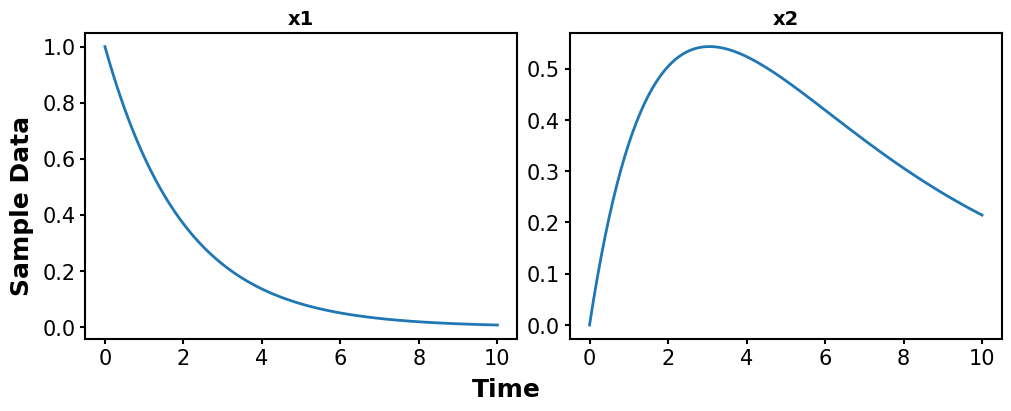

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (10,4), constrained_layout = True)
for i, ax in zip(range(len(init)), axes.flat):
    ax.plot(sample_data.t, sample_data.y[i], label = 'x{}'.format(i+1), lw = 2)
    ax.tick_params(axis='both', which = 'major', labelsize = '15', width = 1.5)
    ax.yaxis.offsetText.set_fontsize(15)
    ax.set_title('x{}'.format(i+1), fontsize = 14, weight = 'bold')
_ = fig.supylabel('Sample Data', fontsize = 18, weight = 'bold')
_ = fig.supxlabel('Time', fontsize = 18, weight = 'bold')
# plt.savefig('hesse_circadian_clock_portion.png', bbox_inches = 'tight', pad_inches = 0.4, dpi = 300)

We define a RMSE objective function in `sample_loss_func`.

In [ ]:
def sample_loss_func(params, data):
    preds = solve_ivp(fun = lambda t, p: sample_model(t, p, params), t_span = [0, 10],
                y0 = [1, 0], t_eval = np.linspace(0, 10, 101), method = 'Radau',
                atol = 1e-12, rtol = 1e-12)
    return np.sqrt(np.sum((preds.y - data.y)**2))

The steps for training and estimating the parameters are mentioned below.

**Step 1:** Initialize $k_1$ and $k_2$ with a guess.

**Step 2:** Solve the system of ODEs for the guess and obtain a prediction. (Use the `Radau` based solver for this step.)

**Step 3:** Compute the objective/loss function using the prediction and the data.

**Step 4:** Update the guess based on the loss function and go to Step 2.

**Step 5:** Stop the iterations when the desired tolerance for the error is reached.

Steps 4 and 5 are already implemented in the `minimize` routine from the SciPy package. However, we still have to implement the objective function and ensure that it does the task for steps 1, 2 and 3.

In [14]:
init_guess = [0.1, 0.1]
est_params = minimize(sample_loss_func, init_guess, args = (sample_data), method = 'SLSQP', options = {'disp': True, 'ftol': 1e-3})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0021906492008183192
            Iterations: 12
            Function evaluations: 58
            Gradient evaluations: 12


We have used fairly high tolerances for this demonstration. The resulting parameters are a good match but they can be further improved by tuning the tolerance and other parameters for the solver and the optimizer.

In [ ]:
print('True Params: ', true_params)
print('Estimated Params: ', est_params.x)

True Params:  [0.5, 0.2]
Estimated Params:  [0.5003035  0.19988978]


# Negative Feedback Loop for Circadian Clocks

Back to the circadian clocks and how to model them.

It can be observed from the previous checkpoints that we were highly committed to a fairly large model. However, the parameter estimation for this large model using experimental data turned out to be too challenging and we were short on time. The larger model has 18 variables and 64 paramaters. 

Then, we noticed that the drug in question, Li, has a strong impact on only one protein, PER2. In the literature, we often find PER1, PER2 and PER3 as three separate proteins. However, for the sake of simplicity of the model and a general practice in the domain, they are combined as PER. Coming to the circadian clock, it is made of two feedback loops which are driven by the CLOCK/BMAL protein. PER is a part of the negative feedback loop which revolves around PER and CRY proteins and genes with CLOCK/BMAL as the activator (think as driving force for transcription of genes) for the Cry and Per genes.

We thus chose to isolate the negative feedback loop and model it instead of the bigger circadian clock. The isolated loop is further simplified to use only proteins as the variables and the effects and reactions of genes consumed in the protein variables. The variables for the model are mentioned in `species_mapping`. Here, `x1` and `x2` are variables which account for the PER and CRY proteins and genes in a combined form. We can do this simplification provided we account for the transcription of genes and production of proteins in the `x1` and `x2` variables.

We apply the design principles discussed earlier in the notebook such as the proteins and genes degrade, genes lead to production of proteins, export and import of protein complexes to and from the nucleus, etc. The derivative of the concentration for the variables would take the following forms and the relevant parameters can be found in `params_list`.

$\frac{dx_1}{dt}$ = transcription of Per gene + dissociation of PER/CRY complex - formation of PER/CRY complex - degradation of PER protein

$\frac{dx_2}{dt}$ = transcription of Cry gene + dissociation of PER/CRY complex - formation of PER/CRY complex - degradation of CRY protein

$\frac{dx_3}{dt}$ = formation of PER/CRY complex - dissociation of PER/CRY complex + export from nucleus - import to nucleus - degradation of protein

$\frac{dz_1}{dt}$ = import from nucleus - export to nucleus - degradation of protein

Now, the activator for gene transcription (CLOCK/BMAL) is not in the loop but the inhibitor (nucleic complex of PER/CRY) is in the loop. So we simplify the expression from
$$\frac{1 + a\left(\frac{x_a}{ar}\right)^b}{1 + \left(\frac{x_a}{ar}\right)^b + \left(\frac{x_a}{ar}\right)^b\left(\frac{x_i}{ir}\right)^c}$$
to
$$\frac{1}{1 + \left(\frac{x_i}{ir}\right)^c}$$
to negate the impact of the activator. The impact of this simplification is discussed later in the notebook. The above expressions have $x_i$ and $x_a$ to denote inhibitor and activator concentrations respectively. Additionally, they have $ir$ and $ar$ to denote inhibition and activation rate. The exponents are Hill coefficients. The expression can finally be written as 
$$\frac{ir^c}{ir^c + x_i^c}$$
which is also the form we are using the code.

Thus, the simplified model has 4 variables and 13 parameters. (Much much less than the large model in Hesse et al. [1])

Lastly, we need to account for the change in concentration of Li in the body/cell. We have observed in Wood et al. [3] that the concentration shows an exponential reduction with time and spikes when we administer a dose. We thus have the following derivative for Li concentration:
$$\frac{dc}{dt} = - k C + input$$

In [16]:
species_mapping = {
    "x1": "PER",
    "x2": "CRY",
    "x3": "PER/CRY_C", # cytoplasmic complex of PER/CRY
    "z1": "PER/CRY_N", # nucleic complex of PER/CRY
    "c": "Li conc."
}
params_list = [
    # degradation rates
    'dr_x1', 'dr_x2', 'dr_x3',
    'dr_z1',
    # reaction rates for complex formation/dissociation
    'kf_x3', 'kd_x3',
    # transcription rates
    'tr_x1', 'tr_x2',
    # activation/inhibition rates
    'ir_z1',
    # import/export rates
    'impr_x3',
    'expr_z1',
    # hill coefficients
    'n', 'm'
]

We initialize a guess for the parameters.

In [ ]:
def initialize_params():
    '''
    Args >>>
    - literature: boolean
    
    To use the parameters from the literature, set the boolean to True.
    These parameters from the literature are to test and validate our results.
    '''
    values = np.concatenate((
        np.random.rand(4) / 10, # degradation rates
        np.random.rand(1), # reaction rates for complex formation
        np.random.rand(1), # reaction rates for complex dissociation
        np.random.rand(2) * 10, # transcription rates
        np.random.rand(1), # inhibition rates
        np.random.rand(2) / 10, # import/export rates
        np.ones(2) # hill coefficients
    ))
    return pd.Series(values, params_list)

Here, `negative_feedback_loop` computes the derivatives for all the concentrations and later helps the solver to arrive at a solution/prediction.

In [18]:
def negative_feedback_loop(t, species, params, inp = 0):
    '''
    function to compute the odes in the negative feedback loop and the ode for Li concentration
    Args >>>
    - t: time
    - species: concentraion of proteins
    - params: values of parameters
    - inp: input dose of Li
    '''
    # unpacking the values of the proteins
    x1, x2, x3 = species[:3]
    z1 = species[3]
    c = species[4]
    ratio = 0.9 / 0.1 # ratio between volume of cytoplasm and nucleus based on data in the literature
    K = 0.269 # Li decay in rats based on data in the literature

    # ode for lithium concentration
    dcdt = -K * c + inp

    # odes for nucleic proteins and their complexes
    dz1dt = params['impr_x3'] * x3 - params['expr_z1'] * z1 - params['dr_z1'] * z1
    
    # odes for cytoplasmic proteins and their complexes
    dxidthelper = params['ir_z1']**params['n'] / (z1**params['n'] + params['ir_z1']**params['n'])
    if inp == 0:
        dx1dthelper = 1
    else:
        dx1dthelper = (c**params['m'] + params['ir_z1']**params['m']) / params['ir_z1']**params['m']
    dx1dt = params['tr_x1'] * dxidthelper * dx1dthelper + params['kd_x3'] * x3 - params['kf_x3'] * x1 * x2 - params['dr_x1'] * x1
    dx2dt = params['tr_x2'] * dxidthelper + params['kd_x3'] * x3 - params['kf_x3'] * x1 * x2 - params['dr_x2'] * x2
    dx3dt = params['kf_x3'] * x1 * x2 - params['kd_x3'] * x3 + ratio * params['expr_z1'] * z1 - ratio * params['impr_x3'] * x3 - params['dr_x3'] * x3
    
    odes = [dx1dt, dx2dt, dx3dt, dz1dt, dcdt]
    return np.array(odes).reshape(-1,)

In [28]:
class NegativeFeedbackLoop:
    '''
    NegativeFeedbackLoop is a class to aid the creation of the model, simplify solving the odes and act as a utility for model training and parameter optimization.
    '''
    def __init__(self, init, t_start, t_end, dt, params):
        # initial value of the variables -> genes and proteins
        self.init = init
        # time based variables -> start time of the simulation, end time and time step
        self.t_start = t_start
        self.t_end = t_end
        self.dt = dt
        self.t_eval = np.linspace(t_start, t_end, int((t_end - t_start)/dt) + 1)
        # parameters for the system of odes
        self.params = params
        
    def solver(self, params = None, method = 'Radau', atol = 1e-9, rtol = 1e-9, inp = 0):
        '''
        Args >>>
        - params: values for the parameters
        - method, atol, rtol: for the solver
        - inp: input dose of Li
        '''
        if params is not None:
            parameters = params
        else:
            parameters = self.params
        return solve_ivp(
            fun = lambda t, p: negative_feedback_loop(t, p, parameters.to_dict(), inp),
            t_span = [self.t_start, self.t_end],
            y0 = list(self.init.values()),
            t_eval = self.t_eval,
            method = method,
            atol = atol,
            rtol = rtol
        )
    
    def processing_solution(self, solution, params = None, proc_end = None, interval = 48, jumps = 4):
        '''
        Args >>>
        - solution: from the solver
        - params: value of parameters for the odes
        - proc_end: last time step to consider for the processing
        - interval: duration of the ode to process
        - jumps: resolution of the duration
        
        We have experimental data on protein properties which are a linear combination of the protein variables in the odes.
        To compare the solution of the odes with experimental data, we need to process the solution to arrive at the desired format
        '''
        if params is not None:
            parameters = params
        else:
            parameters = self.params
        if proc_end is not None:
            proc_end = proc_end
        else:
            proc_end = self.t_end
        slice_start = int((proc_end - interval) / self.dt)
        slice_end = int(proc_end / self.dt)
        slice_step = int(jumps / self.dt)
        out = solution.y[:, slice_start:slice_end:slice_step]
        proteins = np.zeros((2, out.shape[1]))
        # vc and vn are fractions to denote the volume of cytoplasm and nucleus respectively, and they "should" add to 1
        # total = parameters['vc'] + parameters['vn']
        proteins[0] = 0.9 * out[0] + 0.9 * out[2] + 0.1 * out[3]
        proteins[1] = 0.9 * out[1] + 0.9 * out[2] + 0.1 * out[3]
        return proteins
    
    def objective_function(self, params, protein_targets, method = 'Radau', atol = 1e-9, rtol = 1e-9):
        '''
        Args >>>
        - protein_targets: data from experiments
        
        We define the objective function to optimize the parameters for the odes
        The objective function has the form of least squares
        '''
        # solver attempts to solve the equation and get the predictions
        solution = self.solver(pd.Series(params, params_list), method, atol, rtol)
        # process the predictions to get a desired format
        protein_preds = self.processing_solution(solution, pd.Series(params, params_list).to_dict(), 48)
        protein_preds = protein_preds[:, :6]
        protein_preds = np.resize(protein_preds, protein_targets.shape)
        diff_protein = protein_targets - protein_preds
        # return the least squares (RMSE) objective function
        return np.sqrt(np.mean((diff_protein)**2))


In [ ]:
# biological constraint on the transcription rate of per gene
def per_constraint(params):
    temp = pd.Series(params, params_list).to_dict()
    return 5e-9 - temp['tr_x1'] * 1e-9

# biological constraint on the transcription rate of cry gene
def cry_constraint(params):
    temp = pd.Series(params, params_list).to_dict()
    return 5e-9 - temp['tr_x2'] * 1e-9

We borrowed data from Narumi et al. [4]

The protein data for PER and CRY was processed such that,
$$PER = PER1 + PER2 + PER3$$
$$CRY = CRY1 + CRY2 + CRY3$$

These measured values are in attomol/microgram which was then converted to mol/L.

Additionally, the measured values are all forms of the species. PER measurement accounts for PER and PER/CRY complexes inside and outside nucleus.
So the parameter optimization has to happen on an updated form of the predictions.
$$PER_{tot} = v_c \left(PER + PER/CRY_C\right) + v_n PER/CRY_N$$
Here, $v_c$ and $v_n$ denote the volume proportion of the cytoplasm and nucleus. We found that the value of $v_n$ is roughly 0.1, so we have stuck with this estimated value. [5]

In [30]:
# loading the processed data for proteins
protein_data = pd.read_csv('processed_protein.csv')

In [31]:
protein_data

,protein,ct0,ct4,ct8,ct12,ct16,ct20
0,BMAL,3.833670e-07,4.646170e-07,4.058170e-07,3.988670e-07,3.124000e-07,3.774330e-07
1,CLOCK,3.098830e-07,4.138500e-07,3.903830e-07,3.894670e-07,2.717170e-07,3.003330e-07
2,CRY,7.263250e-07,5.913130e-07,4.434380e-07,4.062130e-07,5.385880e-07,7.434250e-07
3,PER,2.507170e-07,1.020670e-07,7.165000e-08,2.489170e-07,4.560830e-07,4.481170e-07
4,REVERB,4.093330e-08,1.609330e-07,9.560000e-07,5.982830e-07,1.878500e-07,6.260000e-08
5,ROR,3.082000e-07,1.551500e-07,6.445000e-08,1.260000e-07,2.355000e-07,3.431000e-07


In [32]:
protein_data['id'] = ['x5', 'x6', 'x2', 'x1', 'x3', 'x4']

In [33]:
protein_data.sort_values('id')[:2]

,protein,ct0,ct4,ct8,ct12,ct16,ct20,id
3,PER,2.507170e-07,1.020670e-07,7.165000e-08,2.489170e-07,4.560830e-07,4.481170e-07,x1
2,CRY,7.263250e-07,5.913130e-07,4.434380e-07,4.062130e-07,5.385880e-07,7.434250e-07,x2


In [34]:
protein_targets = protein_data.sort_values('id')[:2].filter(regex='ct').to_numpy()

In [35]:
p = initialize_params()
init = {'x1': 0.1504302,
        'x2': 0.47560800000000003,
        'x3': 0.0752151,
        'z1': 0.0250717,
        'c': 0}
t_start = 0
t_end = 600
dt = 0.1
t_eval = np.linspace(t_start, t_end, int((t_end - t_start)/dt) + 1)
loop_train = NegativeFeedbackLoop(init, t_start, t_end, dt, p)

In [36]:
# optimizing the parameters for the negative feedback loop
opt_params = minimize(loop_train.objective_function, loop_train.params, method = 'SLSQP', 
                      args = (protein_targets * 1e6, 'Radau', 1e-12, 1e-12),
                      options = {'ftol': 1e-3, 'maxiter': 500, 'disp': True},
                      constraints = [{'type': 'ineq', 'fun': per_constraint},
                                     {'type': 'ineq', 'fun': cry_constraint}],
                      bounds = [(1e-4, 3)] * 4 + [(0, None) for i in range(loop_train.params.shape[0] - 6)] + [(1,1)] * 2
                     )

/home/ketch/anaconda3/envs/dacs/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/ketch/anaconda3/envs/dacs/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/home/ketch/anaconda3/envs/dacs/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:498: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14794992793568823
            Iterations: 10
            Function evaluations: 136
            Gradient evaluations: 10


In [37]:
opt_params

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.14794992793568823
       x: [ 2.454e+00  1.294e+00 ...  1.000e+00  1.000e+00]
     nit: 10
     jac: [-3.107e-04 -8.197e-03 ...        nan        nan]
    nfev: 136
    njev: 10

In [38]:
# creating multiple instances of the feedback loop to later test with different Li concentration
loop1 = NegativeFeedbackLoop(init, t_start, t_end, dt, pd.Series(opt_params.x.copy(), params_list))
loop2 = NegativeFeedbackLoop(init, t_start, t_end, dt, pd.Series(opt_params.x.copy(), params_list))
loop3 = NegativeFeedbackLoop(init, t_start, t_end, dt, pd.Series(opt_params.x.copy(), params_list))
loop4 = NegativeFeedbackLoop(init, t_start, t_end, dt, pd.Series(opt_params.x.copy(), params_list))
loop5 = NegativeFeedbackLoop(init, t_start, t_end, dt, pd.Series(opt_params.x.copy(), params_list))

The Hill coefficient $n$ is set to 9 based on qualitative observation of the solutions. The thumb rule used here is to ensure that the solver takes finite time to solve the system of ODEs. Increasing the Hill coefficient values leads to increase in time for solving. However, we want a larger number for the coefficient as the lower values do not capture the complexity and variation entirely.

In [ ]:
loop1.params['n'] = 9
loop2.params['n'] = 9
loop3.params['n'] = 9
loop4.params['n'] = 9
loop5.params['n'] = 9

In [40]:
loop1.params

dr_x1      2.453857e+00
dr_x2      1.293570e+00
dr_x3      1.000000e-04
dr_z1      1.630935e-01
kf_x3      1.178044e+00
kd_x3      2.154028e-01
tr_x1      3.931358e+00
tr_x2      4.560146e+00
ir_z1      1.861609e-02
impr_x3    2.260046e-01
expr_z1    4.328731e-18
n          9.000000e+00
m          1.000000e+00
dtype: float64

Solving the system of ODEs for Li doses, specifically, 1 mM, 2 mM, 5 mM and 10 mM.

In [ ]:
soln1 = loop1.solver(method = 'Radau', atol = 1e-12, rtol = 1e-12)
soln2 = loop2.solver(method = 'Radau', atol = 1e-12, rtol = 1e-12, inp = 1e-3)
soln3 = loop3.solver(method = 'Radau', atol = 1e-12, rtol = 1e-12, inp = 2e-3)
soln4 = loop4.solver(method = 'Radau', atol = 1e-12, rtol = 1e-12, inp = 5e-3)
soln5 = loop5.solver(method = 'Radau', atol = 1e-12, rtol = 1e-12, inp = 10e-3)

Now we plot the solutions and we have the following observations.
- The solution is not cyclic and it is expected. The cyclic nature of the clock is due to the interaction between both the loops and CLOCK/BMAL protein is the driving factor for both the loops. As the simplified model excludes the activator, and thus the solution dies out after a few oscillations.
- The amplitude of the oscillation increases with the increase in Li dose.
- Li enhances PER protein levels, decreases CRY protein levels, and increases the nuclear PER/CRY complex at higher doses which is consistent with experimental data in Li et al. [6]
- This leads to lengthening of the circadian period and increased amplitude of molecular oscillations.
- The system has multiple solutions due to the partial nature of the loop. However, the solutions give similar observations.

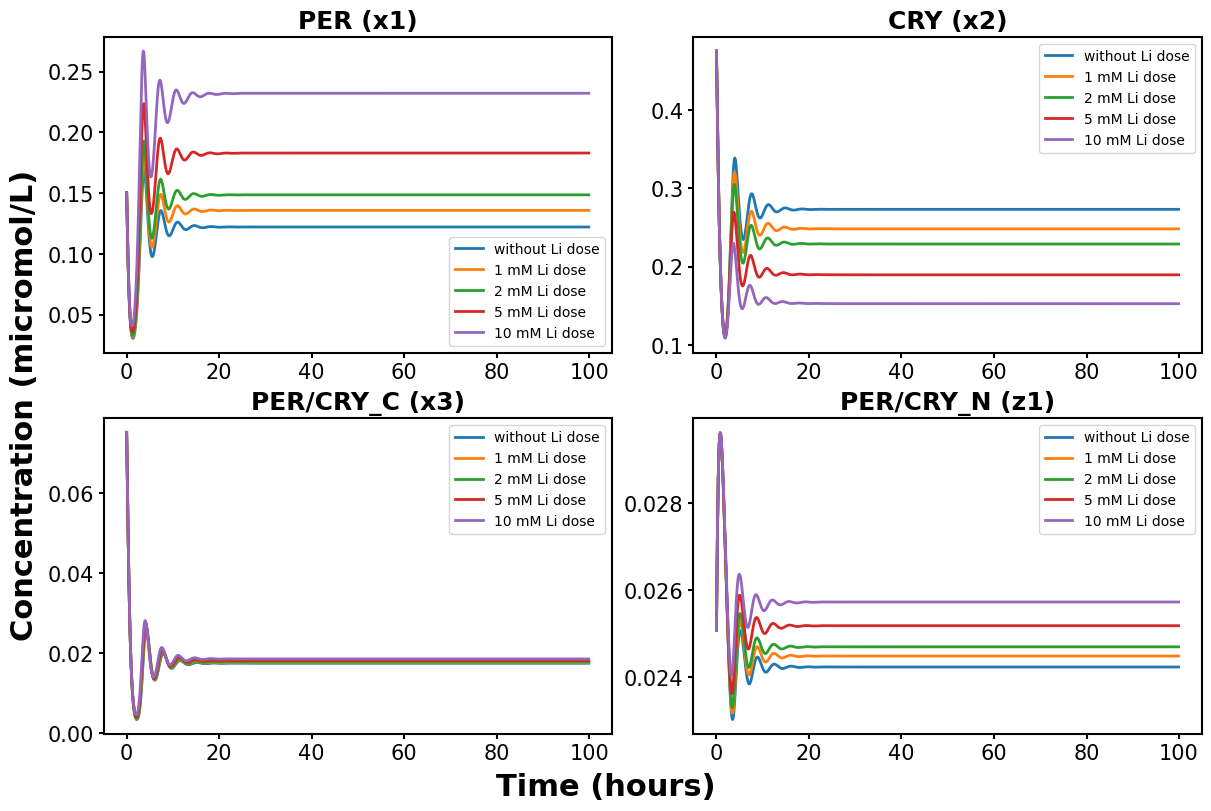

In [ ]:
plt_start = int(t_start / dt)
plt_end = int((t_end - 500)/ dt)
fig, axes = plt.subplots(2, 2, figsize = (12, 8), constrained_layout = True)
for i, ax in zip(range(len(init)), axes.flat):
    time = soln2.t[plt_start:plt_end]
    ax.plot(time, soln1.y[i, plt_start:plt_end], label = 'without Li dose', lw = 2)
    ax.plot(time, soln2.y[i, plt_start:plt_end], label = '1 mM Li dose', lw = 2)
    ax.plot(time, soln3.y[i, plt_start:plt_end], label = '2 mM Li dose', lw = 2)
    ax.plot(time, soln4.y[i, plt_start:plt_end], label = '5 mM Li dose', lw = 2)
    ax.plot(time, soln5.y[i, plt_start:plt_end], label = '10 mM Li dose', lw = 2)
    ax.tick_params(axis='both', which = 'major', labelsize = '15', width = 1.5)
    ax.legend()
    ax.yaxis.offsetText.set_fontsize(15)
    var = list(init.keys())[i]
    ax.set_title('{} ({})'.format(species_mapping[var], var), fontsize = 18, weight = 'bold')
_ = fig.supylabel('Concentration (micromol/L)', fontsize = 22, weight = 'bold')
_ = fig.supxlabel('Time (hours)', fontsize = 22, weight = 'bold')
# plt.savefig('circadian_clock_portion.png', bbox_inches = 'tight', pad_inches = 0.4, dpi = 300)

# References

[1] Hesse, J., Martinelli, J., Aboumanify, O., Ballesta, A., & Relógio, A. (2021). A mathematical model of the circadian clock and drug pharmacology to optimize irinotecan administration timing in colorectal cancer. Computational and Structural Biotechnology Journal, 19, 5170-5183.

[2] Relógio, A., Westermark, P. O., Wallach, T., Schellenberg, K., Kramer, A., & Herzel, H. (2011). Tuning the mammalian circadian clock: robust synergy of two loops. PLoS computational biology, 7(12), e1002309.

[3] Wood, A. J., Goodwin, G. M., De Souza, R., & Green, A. R. (1986). The pharmacokinetic profile of lithium in rat and mouse; an important factor in psychopharmacological investigation of the drug. Neuropharmacology, 25(11), 1285-1288.

[4] Narumi, R., Shimizu, Y., Ukai-Tadenuma, M., Ode, K. L., Kanda, G. N., Shinohara, Y., ... & Ueda, H. R. (2016). Mass spectrometry-based absolute quantification reveals rhythmic variation of mouse circadian clock proteins. Proceedings of the National Academy of Sciences, 113(24), E3461-E3467.

[5] https://bionumbers.hms.harvard.edu/bionumber.aspx?id=113848&ver=0&trm=cytoplasm+nucleus+ratio&org=

[6] Li, J., Lu, W. Q., Beesley, S., Loudon, A. S., & Meng, Q. J. (2012). Lithium impacts on the amplitude and period of the molecular circadian clockwork. PloS one, 7(3), e33292.